## 데이터 로드 및 기본 전처리

In [14]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
import warnings;warnings.filterwarnings('ignore')
import re

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics


pd.options.mode.copy_on_write = True
plt.rcParams['font.family'] ='AppleGothic'
plt.rcParams['axes.unicode_minus'] =False

# 데이터를 load (역세권 여부 추가한 데이터를 불러오겠습니다.)
dt = pd.read_csv('../data/train_v3.csv')
dt_test = pd.read_csv('../data/test_v3.csv')
subway = pd.read_csv('../data/subway_feature.csv')

# 전처리 편의를 위해 컬럼명 조정
subway = subway.rename(columns={'위도': '좌표Y', '경도': '좌표X'})

# 하나의 데이터로 만들어줍니다.
dt['is_test'] = 0
dt_test['is_test'] = 1
dt_test['index'] += (dt['index'].max()+1)
concat = pd.concat([dt, dt_test])
concat = concat.rename(columns={'전용면적(㎡)':'전용면적', 'k-전용면적별세대현황(60㎡이하)':'60m이하', 'k-전용면적별세대현황(60㎡~85㎡이하)':'85m이하', 'k-85㎡~135㎡이하':'135m이하', 'k-135㎡초과':'135m초과'})


display(concat.shape)
display(concat.columns)
display(concat.isnull().sum())

(1101129, 56)

Index(['index', '시군구', '번지', '본번', '부번', '아파트명', '전용면적', '계약년월', '계약일', '층',
       '건축년도', '도로명', '해제사유발생일', '등기신청일자', '거래유형', '중개사소재지',
       'k-단지분류(아파트,주상복합등등)', 'k-전화번호', 'k-팩스번호', '단지소개기존clob', 'k-세대타입(분양형태)',
       'k-관리방식', 'k-복도유형', 'k-난방방식', 'k-전체동수', 'k-전체세대수', 'k-건설사(시공사)',
       'k-시행사', 'k-사용검사일-사용승인일', 'k-연면적', 'k-주거전용면적', 'k-관리비부과면적', '60m이하',
       '85m이하', '135m이하', '135m초과', 'k-홈페이지', 'k-등록일자', 'k-수정일자', '고용보험관리번호',
       '경비비관리형태', '세대전기계약방법', '청소비관리형태', '건축면적', '주차대수', '기타/의무/임대/임의=1/2/3/4',
       '단지승인일', '사용허가여부', '관리비 업로드', '단지신청일', 'target', '주소', '좌표X', '좌표Y',
       'station_area', 'is_test'],
      dtype='object')

index                        0
시군구                          0
번지                         227
본번                          75
부번                          75
아파트명                      2135
전용면적                         0
계약년월                         0
계약일                          0
층                            0
건축년도                         0
도로명                          0
해제사유발생일                1095035
등기신청일자                       0
거래유형                         0
중개사소재지                       0
k-단지분류(아파트,주상복합등등)      852043
k-전화번호                  851620
k-팩스번호                  854118
단지소개기존clob             1031995
k-세대타입(분양형태)            850895
k-관리방식                  850895
k-복도유형                  851224
k-난방방식                  850895
k-전체동수                  851977
k-전체세대수                 850895
k-건설사(시공사)              852407
k-시행사                   852604
k-사용검사일-사용승인일           851029
k-연면적                   850895
k-주거전용면적                850940
k-관리비부과면적               850895
60m이하   

역세권(station_area) one-hot-encoding

In [15]:
concat = pd.get_dummies(concat, columns=['station_area'])

계약년월에 따른 실거래가격지수 추가

In [16]:
price_index = pd.read_csv('../data/실거래가격지수.csv', encoding="utf-8")
price_index['계약년월'] = price_index['시점'].apply(lambda x : int("{:.2f}".format(x).replace('.', '')))
price_index['실거래가격지수'] = price_index['서울']
concat = concat.merge(price_index[['계약년월', '실거래가격지수']], on='계약년월')

아파트 평균 거래가격 추가

In [17]:
# base_mean = pd.read_csv('../data/base_mean.csv', encoding="utf-8")
# concat['recover_num'] = concat.index
# concat_merge = concat.merge(base_mean, on='recover_num', how='left')
# mask = concat_merge['구분date'].isna()
# concat_merge.loc[mask, '구분date'] = concat_merge.loc[mask, '구분date'].fillna(0)
# concat_merge.loc[mask, 'mean'] = concat_merge.loc[mask, 'mean'].fillna(0)
# concat = concat_merge

규모별매매평균가격

In [18]:
price = pd.read_csv('../data/규모별매매평균가격.csv', encoding="utf-8")
price = price.drop(index=0, axis=0)
price.rename(columns={
    '시점': '시점',
    '초소형(40㎡ 이하)': 1,
    '소형(40㎡초과 60㎡이하)': 2,
    '중소형(60㎡초과 85㎡이하)': 3,
    '중대형(85㎡초과 135㎡이하)': 4,
    '대형(135㎡ 초과)': 5
}, inplace=True)
price['계약년월'] = price['시점'].apply(lambda x : int(x.replace('.', '')))
price.set_index('계약년월', inplace=True)
price[[1, 2, 3, 4, 5]] = price[[1, 2, 3, 4, 5]].astype(np.float64)*100

# 전용면적에 따라 적절한 구간 컬럼을 선택
def select_area_column(x):
    if x <= 40:
        return 1
    elif x <= 60:
        return 2
    elif x <= 85:
        return 3
    elif x <= 135:
        return 4
    else:
        return 5

# 새로운 컬럼을 추가하여 면적 구간 컬럼을 저장
concat['면적구간'] = concat['전용면적'].apply(select_area_column)

def conversion(row):
    y = row['계약년월']
    x = row['면적구간']
    return price.loc[y, x]


concat['mean_price'] = concat[['계약년월', '면적구간']].apply(conversion, axis=1)

# '가격' 컬럼을 'mean_price' 컬럼으로 변경
concat = concat.rename(columns={'가격': 'mean_price'})

전체 층수 컬럼 추가

In [19]:
max_floor = concat.groupby('주소')['층'].max()
concat = concat.merge(max_floor, on='주소').rename(columns={'층_y': '최대층수'})


지하철 거리 추가

In [20]:
from math import radians, cos, dist

def GCS_to_meter(x1, y1, x2, y2):
    meter_y = 6371 * radians(1)
    meter_x = meter_y * cos(radians((y1+y2)/2))
    x = list(map(lambda x : x * meter_x, (x1 , x2)))
    y = list(map(lambda x : x * meter_y, (y1 , y2)))
    distance = dist((x[0], y[0]), (x[1], y[1]))
    return distance*1000

apt_coordinate = concat.drop_duplicates(subset='주소')[['주소', '좌표X', '좌표Y']]
station_dist_df = pd.DataFrame()
for apt_address, apt_x, apt_y in apt_coordinate.values:
    station_dist = []
    for sub_x, sub_y in subway[['좌표X', '좌표Y']].values:
        station_dist.append(GCS_to_meter(sub_x, sub_y, apt_x, apt_y))
    station_dist_df = pd.concat([station_dist_df, pd.DataFrame([[apt_address, min(station_dist)]], columns=['주소', '지하철거리'])])

    
concat = concat.merge(station_dist_df, on='주소')

In [21]:
# 결측치 중 아무 의미도 갖지 않는 element를 결측치로 처리하겠습니다.
concat['등기신청일자'] = concat['등기신청일자'].replace(' ', np.nan)
concat['거래유형'] = concat['거래유형'].replace('-', np.nan)
concat['중개사소재지'] = concat['중개사소재지'].replace('-', np.nan)
concat['건축면적'] = concat['건축면적'].replace(0, np.nan)
concat['주차대수'] = concat['주차대수'].replace(0, np.nan)

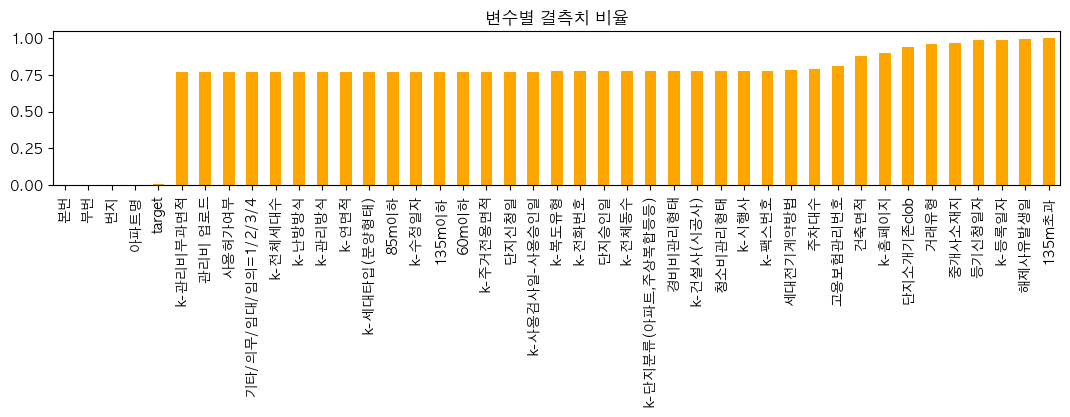

In [22]:
# 변수별 결측치의 비율을 plot으로 그려보면 아래와 같습니다.
fig = plt.figure(figsize=(13, 2))
missing = concat.isnull().sum() / concat.shape[0]
missing = missing[missing > 0]
missing.sort_values(inplace=True)
missing.plot.bar(color='orange')
plt.title('변수별 결측치 비율')
plt.show()

In [23]:
# Null값이 80만개 이상인 칼럼은 삭제해보도록 하겠습니다.
print('* 결측치가 80만개 이하인 변수들 :', list(concat.columns[concat.isnull().sum() <= 800000]))     # 남겨질 변수들은 아래와 같습니다.
print('* 결측치가 80만개 이상인 변수들 :', list(concat.columns[concat.isnull().sum() >= 800000]))

* 결측치가 80만개 이하인 변수들 : ['index', '시군구', '번지', '본번', '부번', '아파트명', '전용면적', '계약년월', '계약일', '층_x', '건축년도', '도로명', 'target', '주소', '좌표X', '좌표Y', 'is_test', 'station_area_0.0', 'station_area_1.0', '실거래가격지수', '면적구간', 'mean_price', '최대층수', '지하철거리']
* 결측치가 80만개 이상인 변수들 : ['해제사유발생일', '등기신청일자', '거래유형', '중개사소재지', 'k-단지분류(아파트,주상복합등등)', 'k-전화번호', 'k-팩스번호', '단지소개기존clob', 'k-세대타입(분양형태)', 'k-관리방식', 'k-복도유형', 'k-난방방식', 'k-전체동수', 'k-전체세대수', 'k-건설사(시공사)', 'k-시행사', 'k-사용검사일-사용승인일', 'k-연면적', 'k-주거전용면적', 'k-관리비부과면적', '60m이하', '85m이하', '135m이하', '135m초과', 'k-홈페이지', 'k-등록일자', 'k-수정일자', '고용보험관리번호', '경비비관리형태', '세대전기계약방법', '청소비관리형태', '건축면적', '주차대수', '기타/의무/임대/임의=1/2/3/4', '단지승인일', '사용허가여부', '관리비 업로드', '단지신청일']


In [25]:
# 위에서 결측치가 80만개 이하인 변수들만 골라 새로운 concat_select 객체로 저장해줍니다.
concat.drop(columns=['번지', '본번', '부번'], inplace=True)
selected = list(concat.columns[concat.isnull().sum() <= 800000])
concat_select = concat[selected]

In [26]:
continuous_columns = []
categorical_columns = []

for column in concat_select.columns:
    if pd.api.types.is_numeric_dtype(concat_select[column]):
        continuous_columns.append(column)
    else:
        categorical_columns.append(column)

print("연속형 변수:", continuous_columns)
print("범주형 변수:", categorical_columns)

연속형 변수: ['index', '전용면적', '계약년월', '계약일', '층_x', '건축년도', 'target', '좌표X', '좌표Y', 'is_test', 'station_area_0.0', 'station_area_1.0', '실거래가격지수', '면적구간', 'mean_price', '최대층수', '지하철거리']
범주형 변수: ['시군구', '아파트명', '도로명', '주소']


좌표 이상치 처리


In [27]:
x_min, y_max = concat_select['좌표X'].min(), concat_select['좌표Y'].max()
concat_select['좌표X'] = concat_select['좌표X'].apply(lambda x: y_max if x == x_min else x)
concat_select['좌표Y'] = concat_select['좌표Y'].apply(lambda y: x_min if y == y_max else y)
concat_select[concat_select['좌표Y'] == y_max]

,index,시군구,아파트명,전용면적,계약년월,계약일,층_x,건축년도,도로명,target,...,좌표X,좌표Y,is_test,station_area_0.0,station_area_1.0,실거래가격지수,면적구간,mean_price,최대층수,지하철거리


In [28]:
# for var in continuous_columns:
#     plt.figure(figsize=(10, 6))
#     plt.scatter(concat_select[var], concat_select['target'])
#     plt.title(f'Target vs {var}')
#     plt.xlabel(var)
#     plt.ylabel('Target')
#     plt.grid(True)
#     plt.show()

In [29]:
concat_select['구'] = concat_select['시군구'].map(lambda x : x.split()[1])
concat_select['동'] = concat_select['시군구'].map(lambda x : x.split()[2])
del concat_select['시군구']

concat_select['계약년'] = concat_select['계약년월'].astype('str').map(lambda x : int(x[:4]))
concat_select['계약월'] = concat_select['계약년월'].astype('str').map(lambda x : int(x[4:]))
del concat_select['계약년월']

In [30]:
df = pd.DataFrame()
char_to_remove = '동'

# 열의 각 문자열에서 'o'가 포함되어 있으면 'o'를 제거하고, 그렇지 않으면 그대로 사용
df['test'] = concat_select['동'].apply(lambda x: x.replace(char_to_remove, '') if char_to_remove in x else x)

In [31]:
df['아파트'] = concat_select['아파트명']
df['test'] = df['test'].astype(str).fillna('')
df['아파트'] = df['아파트'].astype(str).fillna('')

In [32]:
def remove_patterns_and_test(row):
    # 여러 패턴을 정의
    patterns = r'~|,|[A-Z]동|\d+차|\d+단지|\d+호|\d+동|\d'
    # 패턴 제거
    text = re.sub(patterns, '', row['아파트'])
    # 'test' 열의 문자열과 'test' + '동' 패턴 제거
    test_pattern = re.escape(row['test'])
    combined_pattern = fr'{test_pattern}동|{test_pattern}'
    text = re.sub(combined_pattern, '', text)
    return text.strip()
df['아파트'] = df.apply(remove_patterns_and_test, axis=1)

In [33]:
# 문자 사이에 있는 숫자를 제거하는 함수 정의
def remove_digits_between_letters(text):
    # 문자 사이의 숫자를 찾아서 제거하는 정규 표현식 패턴
    pattern = r'(?<=[가-힣a-zA-Z])\d+(?=[가-힣a-zA-Z])'
    return re.sub(pattern, '', text)

# '로' 또는 '길'로 끝나는 패턴을 추출하는 함수 정의
def extract_road_name(text):
    # '로'로 끝나는 패턴을 먼저 추출
    match = re.search(r'.*?로', text)
    if not match:
        # '로'가 없으면 '길'로 끝나는 패턴을 추출
        match = re.search(r'.*?길', text)
    return match.group(0) if match else text

# '도로명' 열의 문자열을 변환하는 함수 정의
def transform_road_name(text):
    # 문자 사이의 숫자를 제거
    text = remove_digits_between_letters(text)
    # '로' 또는 '길'로 끝나는 부분만 남기기
    text = extract_road_name(text)
    return text

# '도로명' 열의 문자열을 변환
df['도로명'] = concat_select['도로명'].apply(transform_road_name)

In [34]:
concat_select['아파트'] = df['아파트'].astype(str)
concat_select['도로'] = df['도로명']
concat_select['아파트명'] = concat_select['아파트명'].astype(str)

In [35]:
all = list(concat_select['구'].unique())
gangnam = ['강서구', '영등포구', '동작구', '서초구', '강남구', '송파구', '강동구']
gangbuk = [x for x in all if x not in gangnam]

assert len(all) == len(gangnam) + len(gangbuk)       # 알맞게 분리되었는지 체크합니다.

# 강남의 여부를 체크합니다.
is_gangnam = []
for x in concat_select['구'].tolist() :
  if x in gangnam :
    is_gangnam.append(1)
  else :
    is_gangnam.append(0)

# 파생변수를 하나 만릅니다.
concat_select['강남여부'] = is_gangnam


display(concat_select['건축년도'].describe(percentiles = [0.1, 0.25, 0.5, 0.75, 0.8, 0.9]))
concat_select['신축여부'] = concat_select['건축년도'].apply(lambda x: 1 if x >= 2010 else 0)

count    1.101129e+06
mean     1.999099e+03
std      9.119692e+00
min      1.961000e+03
10%      1.987000e+03
25%      1.993000e+03
50%      2.000000e+03
75%      2.005000e+03
80%      2.006000e+03
90%      2.010000e+03
max      2.023000e+03
Name: 건축년도, dtype: float64

## 상관분석

k-전체동수, k-전체세대수, k-연면적, k-주거전용면적, k-전용면적별세대현황, 주차대수 컬럼들 끼리의 상관계수가 대부분 강하게 나왔습니다. 그 중 주거전용면적이 가장 상관성이 강하게게 나왔습니다.

상관계수가 강한 위의 피처들 중, 주거전용면적 컬럼을 제외한 나머지 컬럼을 제거하겠습니다.

k-전용면적별세대현황은 '세대 별 평균 전용면적' 컬럼으로 변환하겠습니다.

## 추가 전처리

전용면적이 150이상인 경우 분포가 달라지기때문에 구분하여 모델을 학습하겠습니다.

In [36]:
# 추후 병합을 위해 인덱스 컬럼 생성
# concat_select.reset_index(inplace=True)
# concat_select.drop(columns='level_0', inplace=True)

In [37]:
concat_select.to_csv('../data/final_data.csv', index=False)

In [38]:
import pandas as pd
final_df = pd.read_csv('../data/final_data.csv')

In [39]:
len(final_df)

1101129

In [40]:
import pickle

def calculate_se(target, pred):
    squared_errors = (target - pred) ** 2
    return squared_errors

output_df = pd.DataFrame()
test_score = []
for gu in concat_select['구'].value_counts().keys():
    print(gu)
    concat_select_gu = concat_select[concat_select['구']==gu]
    print(concat_select_gu.shape)
    dt_train = concat_select_gu.query('is_test==0')
    dt_test = concat_select_gu.query('is_test==1')

    # 이제 is_test 칼럼은 drop해줍니다.
    dt_train.drop(['is_test'], axis = 1, inplace=True)
    dt_test.drop(['is_test'], axis = 1, inplace=True)
    dt_test['target'] = 0

    label_encoders = {}
    continuous_columns_v2 = []
    categorical_columns_v2 = []

    for column in dt_train.columns:
        if pd.api.types.is_numeric_dtype(dt_train[column]):
            continuous_columns_v2.append(column)
        else:
            categorical_columns_v2.append(column)

    for col in tqdm( categorical_columns_v2 ):
        lbl = LabelEncoder()


        lbl.fit( dt_train[col].astype(str) )
        dt_train[col] = lbl.transform(dt_train[col].astype(str))
        label_encoders[col] = lbl

        for label in np.unique(dt_test[col]):
            if label not in lbl.classes_:
                lbl.classes_ = np.append(lbl.classes_, label)

        dt_test[col] = lbl.transform(dt_test[col].astype(str))

    assert dt_train.shape[1] == dt_test.shape[1]

    y_train = dt_train['target']
    X_train = dt_train.drop(['target'], axis=1)

    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=2023)

    model = RandomForestRegressor(n_estimators=5, criterion='squared_error', random_state=1, n_jobs=-1)
    model.fit(X_train.drop(columns=['index']), y_train.drop(columns=['index']))
    pred = model.predict(X_val.drop(columns=['index']))

    test_score.append((gu, np.sqrt(metrics.mean_squared_error(y_val, pred))))


    with open('saved_model.pkl', 'wb') as f:
        pickle.dump(model, f)

    X_val['target'] = y_val
    X_val['pred'] = pred

    squared_errors = calculate_se(X_val['target'], X_val['pred'])
    X_val['error'] = squared_errors

    with open('saved_model.pkl', 'rb') as f:
        model = pickle.load(f)

    X_test = dt_test.drop(columns=['target', 'index'])

    real_test_pred = model.predict(X_test)

    preds_df = pd.DataFrame(real_test_pred.astype(int), columns=["target"])

    preds_df_gu = pd.concat([dt_test['index'].reset_index(drop=True),preds_df], axis=1)

    output_df = pd.concat([output_df, preds_df_gu])

output_df.sort_values('index').drop('index', axis=1).to_csv('output.csv', index=False)
print(test_score)


노원구
(114864, 27)


100%|██████████| 7/7 [00:00<00:00, 55.38it/s]


송파구
(72102, 27)


100%|██████████| 7/7 [00:00<00:00, 86.13it/s]


강남구
(65941, 27)


100%|██████████| 7/7 [00:00<00:00, 93.28it/s]


강서구
(65192, 27)


100%|██████████| 7/7 [00:00<00:00, 98.92it/s]


구로구
(57612, 27)


100%|██████████| 7/7 [00:00<00:00, 105.91it/s]


성북구
(56733, 27)


100%|██████████| 7/7 [00:00<00:00, 125.24it/s]


양천구
(54106, 27)


100%|██████████| 7/7 [00:00<00:00, 124.18it/s]


강동구
(53467, 27)


100%|██████████| 7/7 [00:00<00:00, 123.31it/s]


도봉구
(52800, 27)


100%|██████████| 7/7 [00:00<00:00, 141.18it/s]


서초구
(48159, 27)


100%|██████████| 7/7 [00:00<00:00, 127.57it/s]


영등포구
(47738, 27)


100%|██████████| 7/7 [00:00<00:00, 148.31it/s]


마포구
(40512, 27)


100%|██████████| 7/7 [00:00<00:00, 39.33it/s]


동작구
(40371, 27)


100%|██████████| 7/7 [00:00<00:00, 150.76it/s]


동대문구
(39955, 27)


100%|██████████| 7/7 [00:00<00:00, 40.02it/s]


성동구
(39654, 27)


100%|██████████| 7/7 [00:00<00:00, 152.96it/s]


은평구
(38297, 27)


100%|██████████| 7/7 [00:00<00:00, 120.59it/s]


중랑구
(37256, 27)


100%|██████████| 7/7 [00:00<00:00, 67.08it/s]


관악구
(36219, 27)


100%|██████████| 7/7 [00:00<00:00, 179.01it/s]


서대문구
(33096, 27)


100%|██████████| 7/7 [00:00<00:00, 176.27it/s]


광진구
(22221, 27)


100%|██████████| 7/7 [00:00<00:00, 239.27it/s]


강북구
(22135, 27)


100%|██████████| 7/7 [00:00<00:00, 265.40it/s]


용산구
(20509, 27)


100%|██████████| 7/7 [00:00<00:00, 266.58it/s]


금천구
(19655, 27)


100%|██████████| 7/7 [00:00<00:00, 175.31it/s]


중구
(13476, 27)


100%|██████████| 7/7 [00:00<00:00, 416.47it/s]


종로구
(9059, 27)


100%|██████████| 7/7 [00:00<00:00, 473.00it/s]

[('노원구', np.float64(2642.379078390326)), ('송파구', np.float64(7486.01094040799)), ('강남구', np.float64(15883.676834038428)), ('강서구', np.float64(3740.0070248740826)), ('구로구', np.float64(3226.992870207448)), ('성북구', np.float64(3438.044666017232)), ('양천구', np.float64(5295.77540503152)), ('강동구', np.float64(4599.2325045707)), ('도봉구', np.float64(2870.0895306151274)), ('서초구', np.float64(13884.056791217792)), ('영등포구', np.float64(5896.81984131567)), ('마포구', np.float64(5754.223388098948)), ('동작구', np.float64(4755.799517164459)), ('동대문구', np.float64(3442.5751995934656)), ('성동구', np.float64(6720.023872222688)), ('은평구', np.float64(4157.915513803742)), ('중랑구', np.float64(2950.1708305290576)), ('관악구', np.float64(3609.2254372352936)), ('서대문구', np.float64(4406.271240289193)), ('광진구', np.float64(7350.850346431317)), ('강북구', np.float64(2775.9317984140307)), ('용산구', np.float64(16184.041606576124)), ('금천구', np.float64(2860.044026992489)), ('중구', np.float64(7576.7534779928155)), ('종로구', np.float64(7674.20345660

In [41]:
pd.DataFrame(test_score, columns=['gu', 'score'])

,gu,score
0,노원구,2642.379078
1,송파구,7486.010940
2,강남구,15883.676834
3,강서구,3740.007025
4,구로구,3226.992870
5,성북구,3438.044666
6,양천구,5295.775405
7,강동구,4599.232505
8,도봉구,2870.089531
9,서초구,13884.056791


In [42]:
브레이크

NameError: name '브레이크' is not defined

전용면적 150이하인 데이터로 학습시키겠습니다.

In [ ]:
output_df

,target
0,203020
1,122492
2,158200
3,111900
4,202400
...,...
733,47600
734,44300
735,47600
736,98880


In [ ]:
dt_test['target'] = 0

In [ ]:
# 파생변수 제작으로 추가된 변수들이 존재하기에, 다시한번 연속형과 범주형 칼럼을 분리해주겠습니다.
continuous_columns_v2 = []
categorical_columns_v2 = []

for column in dt_train.columns:
    if pd.api.types.is_numeric_dtype(dt_train[column]):
        continuous_columns_v2.append(column)
    else:
        categorical_columns_v2.append(column)

print("연속형 변수:", continuous_columns_v2)
print("범주형 변수:", categorical_columns_v2)

연속형 변수: ['index', '전용면적', '계약일', '층', '건축년도', 'target', '좌표X', '좌표Y', 'station_area', '실거래가격지수', '면적구간', 'mean_price', '계약년', '계약월', '강남여부', '신축여부']
범주형 변수: ['아파트명', '도로명', '주소', '구', '동', '아파트', '도로']


In [ ]:
# 아래에서 범주형 변수들을 대상으로 레이블인코딩을 진행해 주겠습니다.

# 각 변수에 대한 LabelEncoder를 저장할 딕셔너리
label_encoders = {}

# Implement Label Encoding
for col in tqdm( categorical_columns_v2 ):
    lbl = LabelEncoder()

    # Label-Encoding을 fit
    lbl.fit( dt_train[col].astype(str) )
    dt_train[col] = lbl.transform(dt_train[col].astype(str))
    label_encoders[col] = lbl           # 나중에 후처리를 위해 레이블인코더를 저장해주겠습니다.

    # Test 데이터에만 존재하는 새로 출현한 데이터를 신규 클래스로 추가해줍니다.
    for label in np.unique(dt_test[col]):
      if label not in lbl.classes_: # unseen label 데이터인 경우
        lbl.classes_ = np.append(lbl.classes_, label) # 미처리 시 ValueError발생하니 주의하세요!

    dt_test[col] = lbl.transform(dt_test[col].astype(str))
  
  

100%|██████████| 7/7 [00:00<00:00, 28.79it/s]


In [ ]:
assert dt_train.shape[1] == dt_test.shape[1]

In [ ]:
# Target과 독립변수들을 분리해줍니다.
y_train = dt_train['target']
X_train = dt_train.drop(['target'], axis=1)

# Hold out split을 사용해 학습 데이터와 검증 데이터를 8:2 비율로 나누겠습니다.
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=2023)

In [ ]:
# RandomForestRegressor를 이용해 회귀 모델을 적합시키겠습니다.
model = RandomForestRegressor(n_estimators=5, criterion='squared_error', random_state=1, n_jobs=-1)
model.fit(X_train.drop(columns=['index']), y_train.drop(columns=['index']))
pred = model.predict(X_val.drop(columns=['index']))

In [ ]:
# 회귀 관련 metric을 통해 train/valid의 모델 적합 결과를 관찰합니다.
print(f'RMSE test: {np.sqrt(metrics.mean_squared_error(y_val, pred))}')

RMSE test: 14151.11921739929


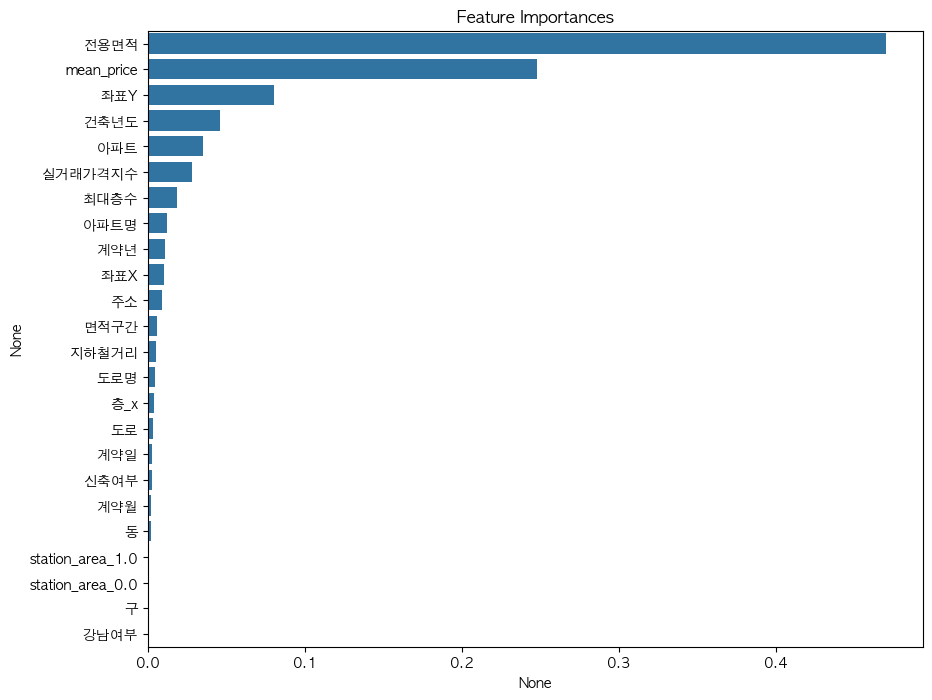

In [ ]:
# 위 feature importance를 시각화해봅니다.
importances = pd.Series(model.feature_importances_, index=list(X_train.columns[1:]))
importances = importances.sort_values(ascending=False)

plt.figure(figsize=(10,8))
plt.title("Feature Importances")
sns.barplot(x=importances, y=importances.index)
plt.show()

In [ ]:
import pickle

# 학습된 모델을 저장합니다. Pickle 라이브러리를 이용하겠습니다.
with open('saved_model.pkl', 'wb') as f:
    pickle.dump(model, f)

In [ ]:
# Validation dataset에 target과 pred 값을 채워주도록 하겠습니다.
X_val['target'] = y_val
X_val['pred'] = pred

In [ ]:
# Squared_error를 계산하는 함수를 정의하겠습니다.


def calculate_se(target, pred):
    squared_errors = (target - pred) ** 2
    return squared_errors

# RMSE 계산
squared_errors = calculate_se(X_val['target'], X_val['pred'])
X_val['error'] = squared_errors

In [ ]:
# Error가 큰 순서대로 sorting 해 보겠습니다.
X_val_sort = X_val.sort_values(by='error', ascending=False)       # 내림차순 sorting

In [ ]:
X_val_sort.head()

,index,아파트명,전용면적,계약일,층,건축년도,도로명,주소,좌표X,좌표Y,...,동,계약년,계약월,아파트,도로,강남여부,신축여부,target,pred,error
704104,704104,1563,273.860,7,5,2002,568,1087,127.002858,37.486201,...,22,2015,1,1134,28,1,0,490000.0,220984.2,7.236950e+10
282075,282075,488,227.370,25,2,2019,2002,2100,127.009903,37.531551,...,61,2021,5,424,100,0,1,400000.0,667600.0,7.160976e+10
439433,439433,844,196.420,13,16,2009,1384,639,127.053405,37.525317,...,53,2017,7,613,63,1,0,440000.0,706200.0,7.086244e+10
218039,218039,1157,195.388,25,3,2004,1523,313,127.059549,37.518398,...,19,2021,12,806,70,1,0,700000.0,450400.0,6.230016e+10
197729,197729,843,244.320,18,5,2006,1386,641,127.054290,37.526479,...,53,2023,3,613,63,1,0,821000.0,572000.0,6.200100e+10


In [ ]:
X_val_sort_top100 = X_val.sort_values(by='error', ascending=False).head(1000)        # 예측을 잘 하지못한 top 100개의 data
X_val_sort_tail100 = X_val.sort_values(by='error', ascending=False).tail(1000)       # 예측을 잘한 top 100개의 data

In [ ]:
# 해석을 위해 레이블인코딩 된 변수를 복원해줍니다.
error_top100 = X_val_sort_top100.copy()
for column in categorical_columns_v2 :     # 앞서 레이블 인코딩에서 정의했던 categorical_columns_v2 범주형 변수 리스트를 사용합니다.
    error_top100[column] = label_encoders[column].inverse_transform(X_val_sort_top100[column])

best_top100 = X_val_sort_tail100.copy()
for column in categorical_columns_v2 :     # 앞서 레이블 인코딩에서 정의했던 categorical_columns_v2 범주형 변수 리스트를 사용합니다.
    best_top100[column] = label_encoders[column].inverse_transform(X_val_sort_tail100[column])

In [ ]:
display(error_top100.head(1))
display(best_top100.head(1))

,index,아파트명,전용면적,계약일,층,건축년도,도로명,주소,좌표X,좌표Y,...,동,계약년,계약월,아파트,도로,강남여부,신축여부,target,pred,error
704104,704104,트라움하우스3,273.86,7,5,2002,명달로 97-14,서울특별시 서초구 서초동명달로 97-14,127.002858,37.486201,...,서초동,2015,1,트라움하우스,명달로,1,0,490000.0,220984.2,7.236950e+10


,index,아파트명,전용면적,계약일,층,건축년도,도로명,주소,좌표X,좌표Y,...,동,계약년,계약월,아파트,도로,강남여부,신축여부,target,pred,error
3210,3210,까치마을,39.6,28,12,1993,광평로19길 10,서울특별시 강남구 수서동광평로19길 10,127.086602,37.485485,...,수서동,2018,8,까치마을,광평로,1,0,80000.0,80100.0,10000.0


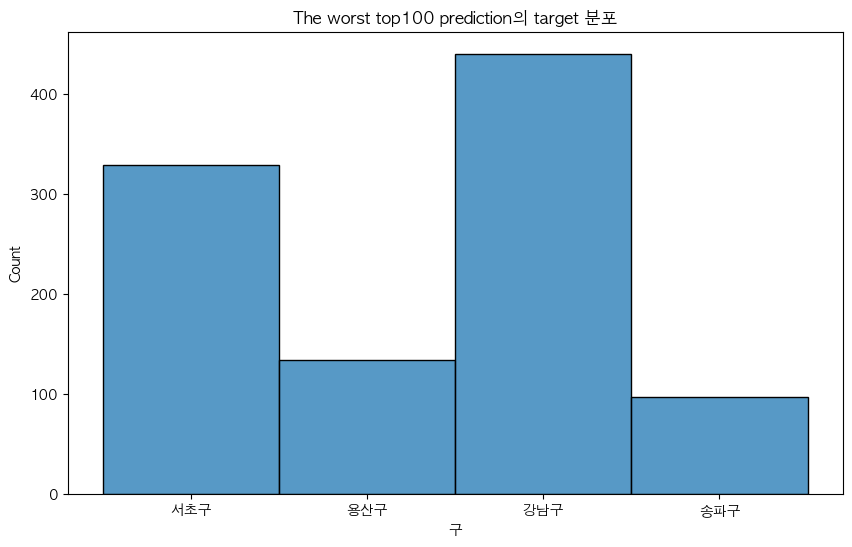

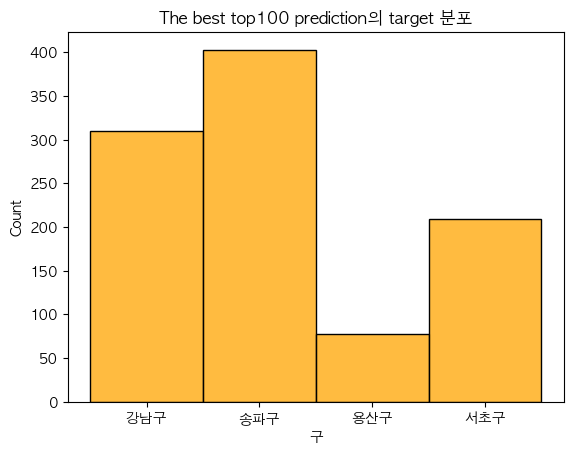

In [ ]:
plt.figure(figsize=(10, 6))
sns.histplot(data = error_top100, x='구')
plt.title('The worst top100 prediction의 target 분포')
plt.show()

sns.histplot(data = best_top100, x='구', color='orange')
plt.title('The best top100 prediction의 target 분포')
plt.show()

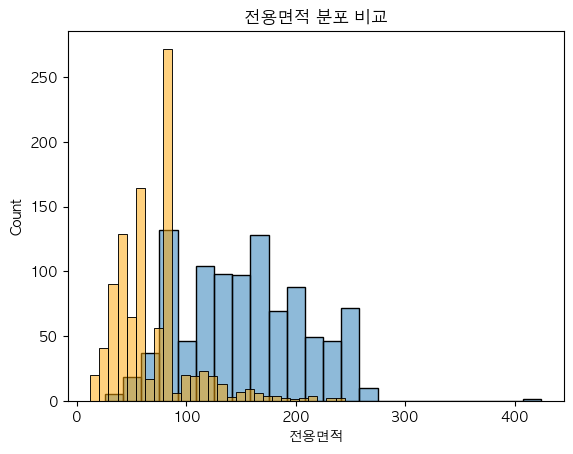

In [ ]:
sns.histplot(data = error_top100, x='전용면적', alpha=0.5)
sns.histplot(data = best_top100, x='전용면적', color='orange', alpha=0.5)
plt.title('전용면적 분포 비교')
plt.show()

In [ ]:
# 저장된 모델을 불러옵니다.
with open('saved_model.pkl', 'rb') as f:
    model = pickle.load(f)

In [ ]:
with open('saved_model.pkl', 'rb') as f:
    model = pickle.load(f)

X_test = dt_test.drop(columns=['target', 'index'])

# Test dataset에 대한 inference를 진행합니다.
real_test_pred = model.predict(X_test)

preds_df = pd.DataFrame(real_test_pred.astype(int), columns=["target"])

preds_df_gu = pd.concat([dt_test['index'].reset_index(drop=True),preds_df], axis=1)

output_df = pd.concat([output_df, preds_df_gu]).sort_values('index').drop('index', axis=1)

output_df.to_csv('output.csv', index=False)


CPU times: user 5.15 ms, sys: 4.96 ms, total: 10.1 ms
Wall time: 19 ms


In [ ]:
real_test_pred

array([188100., 302000., 289600., ..., 121600., 121100., 124800.])

In [ ]:
# 앞서 예측한 예측값들을 저장합니다.
preds_df = pd.DataFrame(real_test_pred.astype(int), columns=["target"])
# preds_df.to_csv('output.csv', index=False)

In [ ]:
preds_df_gu = pd.concat([dt_test['index'].reset_index(drop=True),preds_df], axis=1)

In [ ]:
pd.concat([output_df, preds_df_gu]).sort_values('index').drop('index', axis=1).to_csv('output.csv', index=False)

상관분석

In [ ]:
# # 상관분석을 위해서 결측치는 제거하겠습니다.
# # del concat['k-135㎡초과']
# concat_dropna = concat_select.dropna()
# concat_dropna.shape

# # 아래에서 범주형 변수들을 대상으로 레이블인코딩을 진행해 주겠습니다.

# # 각 변수에 대한 LabelEncoder를 저장할 딕셔너리
# from sklearn.preprocessing import LabelEncoder
# from tqdm import tqdm
# import numpy as np
# label_encoders = {}

# # Implement Label Encoding
# for col in tqdm( continuous_columns_v2 ):
#     lbl = LabelEncoder()

#     # Label-Encoding을 fit
#     lbl.fit( concat_dropna[col].astype(str) )
#     concat_dropna[col] = lbl.transform(concat_dropna.loc[:, col].astype(str))
#     label_encoders[col] = lbl           # 나중에 후처리를 위해 레이블인코더를 저장해주겠습니다.

# plt.rcParams['font.family'] ='AppleGothic'
# plt.rcParams['axes.unicode_minus'] =False

# # 컬럼별 상관계수 계산
# correlation_matrix = concat_dropna[concat_dropna.select_dtypes(exclude=['object']).columns.tolist()].corr()

# # 히트맵 시각화
# plt.figure(figsize=(20, 16))
# sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5, fmt=".1f")
# plt.title('Correlation Matrix Heatmap')
# plt.show()